In [1]:
import torchvision.models as models
import torch
from alexnet_pytorch import AlexNet as alexnet2
from util.layervisualization import CNNLayerVisualization
from util.modelregressions import CNNCrossFit
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# load up target and source models
squeezenet_target = models.squeezenet1_0(pretrained=True).features
squeezenet_source = models.squeezenet1_1(pretrained=True).features
alexnet_source = models.alexnet(pretrained=True).features

# pre-load data into memory for speed
hvmdataset = HVMDataset(5500)

In [3]:
# define basic params 
cnn_layer = 7
source_units = np.arange(128)
target_units = np.arange(128)
img_dim = [256,256,3]

In [4]:
# pre-load data into memory for speed
hvmdataset = HVMDataset(1200)
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet200 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units)
# extract layer activation across two models
snet2snet200.design(hvmdataset,200,1000)
# linear prediction of target unit, record performance
snet2snet200.fit()
# implement source control of target units, record performance
snet2snet200.control()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [30:40<00:00, 14.09s/it]


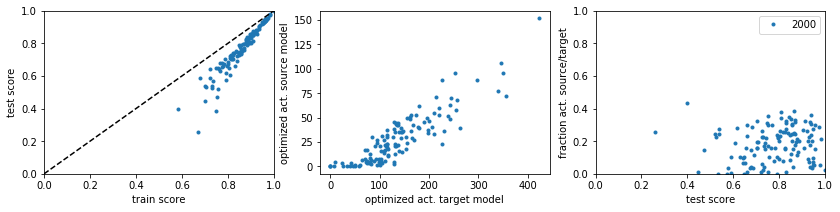

In [5]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet200.train_score,snet2snet200.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet200.target_act,snet2snet200.source_act,'.')
plt.axis('tight')
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet200.test_score,snet2snet200.ctr_score,'.',label='2000')
plt.legend()
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

In [7]:
# create two feature visualization objects
img_dim = [256,256,3]
niter = 100
layer_vis_target = CNNLayerVisualization(squeezenet_target, cnn_layer, target_units[0],img_dim)

# Image sythesis with pytorch hooks
[Img_target, target_val] = layer_vis_target.visualise_layer_with_hooks(niter=niter)

Iteration: 50 Loss: -275.58
Iteration: 100 Loss: -591.62


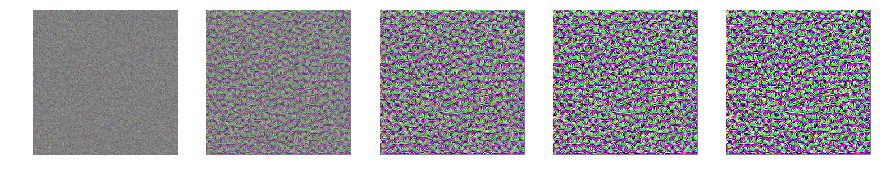

In [9]:
img = np.zeros((img_dim[0]*img_dim[1]*img_dim[2],niter))
plt.figure(figsize=(15,40))
for i in range(niter):
    im_path = 'generated/layer_vis_l' + str(cnn_layer) + \
        '_f' + str(source_units[0]) + '_iter' + str(i+1) + '.jpg'
    tempimg=mpimg.imread(im_path)
    img[:,i] = tempimg.flatten()
    if i%(niter/5) == 0:
        plt.subplot(1,5,round(i/(niter/5))+1)
        plt.imshow(tempimg)
        plt.axis('off')
        plt.clim([0,1])
plt.show()

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA

D = img[:,0:-2:1]-img[:,1:-1:1];
[d,n] = D.shape
pca = PCA(n_components=n,whiten=False)
pca.fit(D)

PCA(copy=True, iterated_power='auto', n_components=98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

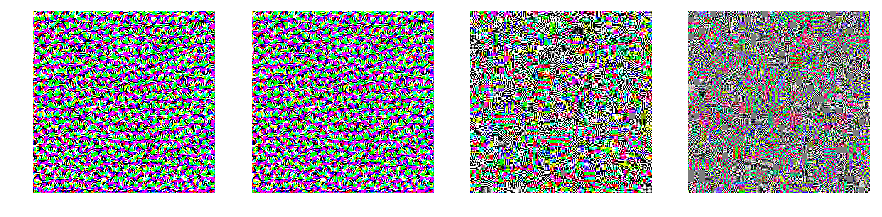

In [14]:
Dpca = pca.transform(D)
Dproj_pc1 = Dpca[:,0].reshape(img_dim)

plt.figure(figsize=(15,40))
plt.subplot(1,4,1)
plt.imshow(float2rgb(tempimg))
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(float2rgb(-Dproj_pc1))
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(float2rgb(D[:,5].reshape(img_dim)))
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(float2rgb(D[:,-5].reshape(img_dim)))
plt.axis('off')
plt.show()

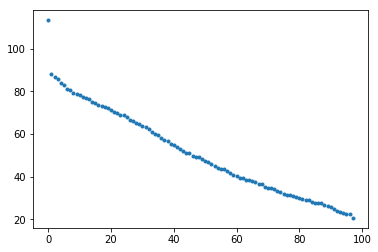

In [13]:
plt.plot(pca.explained_variance_,'.')
plt.show()